In [30]:
# %pip install --force-reinstall \
#   "numpy==1.19.3" \
#   "scipy==1.5.4" \
#   "pandas==1.2.5" \
#   "matplotlib==3.3.2" \
#   "six==1.15.0"


In [31]:
#%pip install "pyedflib==0.1.30"

In [32]:
# Cell 1: imports & config

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# For UCDDB .edf ECG
import pyedflib

# ---- Paths ----
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"

HUGCDN_DIR = DATA_DIR / "HuGCDN2014-OXI"
UCDDB_DIR  = DATA_DIR / "st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0" / "files"

T_STEPS = 200
PRE_APNEA_HORIZON = 1
RANDOM_STATE = 42
EPOCH_LEN_SEC = 60


In [33]:
# Cell 2: HuGCDN helpers (SpO2-only)

def load_hugcdn_labels(path: Path) -> np.ndarray:
    """
    Load per-minute labels from HuGCDN LABELS/*.mat.
    Returns 1D int array of shape (n_epochs,).
    """
    d = loadmat(path)
    if "salida_man_1m" in d:
        raw = d["salida_man_1m"]
    elif "salida_man" in d:
        raw = d["salida_man"]
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    labels = np.ravel(raw).astype(int)
    return labels


def extract_epoch_series(raw) -> list:
    """
    Convert MATLAB cell / numeric array into a list of 1D float arrays, one per epoch.
    """
    arr = np.array(raw)

    if arr.dtype == object:  # cell array
        epochs = []
        for x in arr.ravel():
            x = np.array(x).astype(float).ravel()
            if x.size > 0:
                epochs.append(x)
        return epochs

    # numeric
    arr = np.squeeze(arr)
    if arr.ndim == 1:
        return [arr.astype(float)]
    else:
        return [arr[i, :].astype(float).ravel() for i in range(arr.shape[0])]


def load_hugcdn_sat_epochs(path: Path) -> list:
    """
    Load SpO2 (sat) epochs from HuGCDN SAT/*.mat as a list of arrays.
    """
    d = loadmat(path)
    for name in ["sat", "Sat", "SaO2", "satO2", "SaO2_1m"]:
        if name in d:
            raw = d[name]
            break
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    return extract_epoch_series(raw)


def resize_epoch(x: np.ndarray, target_len: int) -> np.ndarray:
    """
    Simple linear resampling of 1D array x to fixed length target_len.
    """
    x = np.asarray(x, dtype=float).ravel()
    if x.size == 0:
        return np.zeros(target_len, dtype=float)
    if x.size == target_len:
        return x
    old_idx = np.linspace(0.0, 1.0, num=x.size)
    new_idx = np.linspace(0.0, 1.0, num=target_len)
    return np.interp(new_idx, old_idx, x)


def load_hugcdn_subject_spo2(subject_id: str, T: int = T_STEPS):
    """
    Load ONE HuGCDN subject using ONLY SpO2 as the signal.

    Returns
    -------
    X  : (n_epochs, T, 2)  -> channel 0: SpO2_z, channel 1: 0
    y  : (n_epochs,)       -> 0/1 apnea label for that minute
    """
    label_path = HUGCDN_DIR / "LABELS" / f"{subject_id}.mat"
    sat_path   = HUGCDN_DIR / "SAT"    / f"{subject_id}.mat"

    labels = load_hugcdn_labels(label_path)
    sat_ep = load_hugcdn_sat_epochs(sat_path)

    n_labels = len(labels)
    n_sat    = len(sat_ep)

    n_epochs = min(n_labels, n_sat)
    if n_epochs == 0:
        raise ValueError(f"No usable epochs for {subject_id}")

    labels = labels[:n_epochs]
    sat_ep = sat_ep[:n_epochs]

    # resample each epoch to length T
    sat_resampled = np.stack([resize_epoch(e, T) for e in sat_ep], axis=0)

    # per-epoch z-normalize SpO2
    mu = sat_resampled.mean(axis=1, keepdims=True)
    sigma = sat_resampled.std(axis=1, keepdims=True) + 1e-6
    sat_z = (sat_resampled - mu) / sigma

    # channel 0 = SpO2_z, channel 1 = zeros
    zeros = np.zeros_like(sat_z)
    X = np.stack([sat_z, zeros], axis=-1)  # (n_epochs, T, 2)
    y = labels.astype(int)

    return X, y


def load_all_hugcdn_spo2(T: int = T_STEPS):
    """
    Load ALL HuGCDN subjects as SpO2-only epochs.

    Returns
    -------
    X           : (N, T, 2)
    y           : (N,)
    subject_idx : (N,) array of subject IDs
    """
    label_dir = HUGCDN_DIR / "LABELS"
    subject_ids = sorted(f.stem for f in label_dir.glob("*.mat"))

    X_list, y_list, subj_idx = [], [], []

    for sid in subject_ids:
        try:
            X_s, y_s = load_hugcdn_subject_spo2(sid, T=T)
            X_list.append(X_s)
            y_list.append(y_s)
            subj_idx.extend([sid] * len(y_s))
            print(f"HUGCDN {sid}: X={X_s.shape}, y={y_s.shape}")
        except Exception as e:
            print(f"Skipping HUGCDN {sid} due to error: {e}")

    if not X_list:
        raise RuntimeError("No HuGCDN subjects loaded!")

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    subject_idx = np.array(subj_idx)

    print("HuGCDN SpO2-only dataset:", X.shape, y.shape)
    return X, y, subject_idx


In [34]:
# Cell 3: UCDDB (St. Vincent) ECG loader using pyEDFlib, not wfdb

import re
import pyedflib  # <- make sure you pip installed this

def time_str_to_sec(t: str) -> float:
    """
    Convert 'HH:MM:SS' (or 'H:MM:SS') to seconds since start of recording.
    Example: '09:01:17' -> 9*3600 + 1*60 + 17
    """
    parts = t.split(":")
    if len(parts) != 3:
        raise ValueError(f"Not a HH:MM:SS time string: {t}")
    h, m, s = map(int, parts)
    return float(h * 3600 + m * 60 + s)


def parse_respevt_file(path: Path):
    """
    Parse ucddbXXX_respevt.txt and return a list of apnea events
    as (start_sec, end_sec).
    We look for any HH:MM:SS tokens in the line; the first two
    are interpreted as (start, end).
    """
    events = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            tokens = re.split(r"\s+", line)
            times_sec = []
            for tok in tokens:
                if ":" in tok:
                    try:
                        times_sec.append(time_str_to_sec(tok))
                    except ValueError:
                        continue

            if len(times_sec) >= 2:
                start_sec, end_sec = times_sec[0], times_sec[1]
                events.append((start_sec, end_sec))

    return events


def build_minute_labels_from_events(events, total_sec, epoch_len_sec=60):
    """
    Build per-minute 0/1 labels from (start_sec, end_sec) apnea events.
    """
    n_epochs = int(total_sec // epoch_len_sec)
    labels = np.zeros(n_epochs, dtype=int)

    for i in range(n_epochs):
        t0 = i * epoch_len_sec
        t1 = (i + 1) * epoch_len_sec
        for (es, ee) in events:
            # If this 1-min window overlaps any event, mark as apnea=1
            if (es < t1) and (ee > t0):
                labels[i] = 1
                break
    return labels


def load_ucddb_record_ecg(rec_id: str, T: int = T_STEPS):
    """
    Load one UCDDB subject's ECG from the *_lifecard_fixed.edf (if present)
    or the raw *_lifecard.edf, and build per-minute apnea labels
    from *_respevt.txt.

    Returns
    -------
    X : (n_epochs, T, 2)   -> [ECG_z, 0]
    y : (n_epochs,)        -> 0/1 apnea labels
    """
    # Prefer fixed EDF if it exists
    fixed_edf   = UCDDB_DIR / f"{rec_id}_lifecard_fixed.edf"
    raw_edf     = UCDDB_DIR / f"{rec_id}_lifecard.edf"
    respevt_path = UCDDB_DIR / f"{rec_id}_respevt.txt"

    if fixed_edf.exists():
        edf_path = fixed_edf
    else:
        edf_path = raw_edf

    if not edf_path.exists():
        raise FileNotFoundError(edf_path)
    if not respevt_path.exists():
        raise FileNotFoundError(respevt_path)

    # --- Read ECG signal with pyedflib ---
    f = pyedflib.EdfReader(str(edf_path))
    sig_labels = [lab.lower() for lab in f.getSignalLabels()]

    # Try to auto-detect ECG channel
    ecg_idx = None
    for i, lab in enumerate(sig_labels):
        if "ecg" in lab or "ekg" in lab:
            ecg_idx = i
            break
    if ecg_idx is None:
        ecg_idx = 0  # fallback

    fs = f.getSampleFrequency(ecg_idx)
    ecg = f.readSignal(ecg_idx).astype(float)
    f.close()

    total_sec = len(ecg) / fs

    # --- Labels from respevt ---
    events = parse_respevt_file(respevt_path)
    labels = build_minute_labels_from_events(
        events, total_sec, epoch_len_sec=EPOCH_LEN_SEC
    )

    n_epochs = len(labels)
    samples_per_epoch = int(EPOCH_LEN_SEC * fs)
    usable_samples = n_epochs * samples_per_epoch
    ecg = ecg[:usable_samples]

    if usable_samples == 0 or len(ecg) == 0:
        raise ValueError(f"No usable samples for {rec_id}")

    ecg_epochs = ecg.reshape(n_epochs, samples_per_epoch)

    # --- Resample each 1-minute epoch to T ---
    ecg_resampled = np.stack(
        [resize_epoch(e, T) for e in ecg_epochs], axis=0
    )

    # --- Per-epoch z-normalisation ---
    mu = ecg_resampled.mean(axis=1, keepdims=True)
    sigma = ecg_resampled.std(axis=1, keepdims=True) + 1e-6
    ecg_z = (ecg_resampled - mu) / sigma

    zeros = np.zeros_like(ecg_z)
    X = np.stack([ecg_z, zeros], axis=-1)
    y = labels.astype(int)

    return X, y



def load_all_ucddb_ecg(T: int = T_STEPS):
    """
    Load ECG (+ apnea labels) for all UCDDB records that have both
    *_lifecard.edf and *_respevt.txt present.

    Returns
    -------
    X : (N, T, 2)
    y : (N,)
    subject_idx : (N,) record IDs ('ucddb002', etc.)
    """
    edf_files = list(UCDDB_DIR.glob("ucddb*_lifecard.edf"))
    record_ids = sorted(set(f.name.split("_")[0] for f in edf_files))

    print("Found UCDDB records:", record_ids)

    X_list, y_list, subj_idx = [], [], []

    for rec_id in record_ids:
        print(f"\n--- Loading {rec_id} ---")
        try:
            X_r, y_r = load_ucddb_record_ecg(rec_id, T=T)
            print(f"  -> success, X={X_r.shape}, y={y_r.shape}")
            X_list.append(X_r)
            y_list.append(y_r)
            subj_idx.extend([rec_id] * len(y_r))
        except Exception as e:
            print(f"  -> FAILED: {type(e).__name__}: {e}")

    if not X_list:
        raise RuntimeError("No UCDDB ECG records loaded!")

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    subject_idx = np.array(subj_idx)

    print("\nUCDDB ECG-only dataset:", X.shape, y.shape)
    return X, y, subject_idx

def fix_edf_starttime_colons(src_path: Path, dst_path: Path = None):
    """
    Create a 'fixed' copy of an EDF file where the starttime field
    (bytes 176–183) has ':' replaced with '.' so pyedflib stops complaining.
    """
    src_path = Path(src_path)
    if dst_path is None:
        dst_path = src_path.with_name(src_path.stem + "_fixed.edf")

    with open(src_path, "rb") as f:
        data = bytearray(f.read())

    # EDF fixed header is first 256 bytes
    if len(data) < 256:
        raise ValueError("File too small to be valid EDF")

    # Bytes 176–183: starttime in 'hh.mm.ss' format (8 chars)
    starttime_bytes = data[176:184]
    starttime_str = starttime_bytes.decode("ascii", errors="replace")

    # Replace ':' with '.'
    new_starttime_str = starttime_str.replace(":", ".")
    # Ensure exactly 8 chars (EDF field size)
    new_starttime_str = (new_starttime_str + " " * 8)[:8]

    data[176:184] = new_starttime_str.encode("ascii")

    with open(dst_path, "wb") as f:
        f.write(data)

    print(f"Fixed EDF written to: {dst_path}")
    print(f"Old starttime: {repr(starttime_str)}  ->  New: {repr(new_starttime_str)}")

    return dst_path


In [35]:
# Cell 4: pre-apnea labels + model

def make_pre_apnea_labels(y, subject_idx, horizon=1):
    """
    For each epoch t (one minute), label 1 if ANY apnea occurs in
    epochs t+1 .. t+horizon within the SAME subject/record.
    Else 0.
    """
    y = np.asarray(y).astype(int)
    pre_y = np.zeros_like(y)

    unique_subj = np.unique(subject_idx)
    for sid in unique_subj:
        mask = (subject_idx == sid)
        idxs = np.where(mask)[0]
        labels_sub = y[mask]

        for j, global_idx in enumerate(idxs):
            end_j = min(len(labels_sub), j + 1 + horizon)
            if np.any(labels_sub[j+1:end_j] == 1):
                pre_y[global_idx] = 1
            else:
                pre_y[global_idx] = 0

    return pre_y


def build_pre_apnea_model(input_shape):
    """
    Small 1D CNN suitable for eventual TinyML deployment.
    input_shape: (T, 2)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(16, kernel_size=5, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(32, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [36]:
# Cell 4.5: one-time header fix for ALL lifecard EDFs

for edf in UCDDB_DIR.glob("ucddb*_lifecard.edf"):
    try:
        fix_edf_starttime_colons(edf)
    except Exception as e:
        print(f"Failed to fix {edf.name}: {e}")


Fixed EDF written to: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files\ucddb002_lifecard_fixed.edf
Old starttime: '09:01:17'  ->  New: '09.01.17'
Fixed EDF written to: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files\ucddb003_lifecard_fixed.edf
Old starttime: '09:03:58'  ->  New: '09.03.58'
Fixed EDF written to: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files\ucddb005_lifecard_fixed.edf
Old starttime: '09:07:03'  ->  New: '09.07.03'
Fixed EDF written to: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files\ucddb006_lifecard_fixed.edf
Old starttime: '09:08:23'  ->  New: '09.08.23'
Fixed EDF written to: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\s

In [37]:
# Cell 5: combine datasets and build pre-apnea labels

# 1) Load HuGCDN: SpO2-only -> (N_h, T, 2) [ECG=0, SpO2]
X_hug, y_hug_apnea, subj_hug = load_all_hugcdn_spo2(T=T_STEPS)

# 2) Load UCDDB: ECG-only -> (N_u, T, 2) [ECG, SpO2=0]
X_ucd, y_ucd_apnea, subj_ucd = load_all_ucddb_ecg(T=T_STEPS)

# 3) Concatenate
X_all = np.concatenate([X_hug, X_ucd], axis=0)
y_all_apnea = np.concatenate([y_hug_apnea, y_ucd_apnea], axis=0)
subject_all = np.concatenate([subj_hug, subj_ucd], axis=0)

print("Combined dataset:")
print("X_all:", X_all.shape)
print("y_all_apnea:", y_all_apnea.shape)
print("subject_all:", subject_all.shape)

# 4) Build pre-apnea labels
y_all_pre = make_pre_apnea_labels(
    y_all_apnea, subject_all, horizon=PRE_APNEA_HORIZON
)

print("Apnea label distribution:", np.bincount(y_all_apnea))
print("Pre-apnea label distribution:", np.bincount(y_all_pre))


HUGCDN C1: X=(312, 200, 2), y=(312,)
HUGCDN C10: X=(448, 200, 2), y=(448,)
HUGCDN C11: X=(416, 200, 2), y=(416,)
HUGCDN C12: X=(441, 200, 2), y=(441,)
HUGCDN C13: X=(452, 200, 2), y=(452,)
HUGCDN C14: X=(443, 200, 2), y=(443,)
HUGCDN C15: X=(446, 200, 2), y=(446,)
HUGCDN C16: X=(452, 200, 2), y=(452,)
HUGCDN C17: X=(466, 200, 2), y=(466,)
HUGCDN C18: X=(451, 200, 2), y=(451,)
HUGCDN C19: X=(440, 200, 2), y=(440,)
HUGCDN C2: X=(434, 200, 2), y=(434,)
HUGCDN C20: X=(443, 200, 2), y=(443,)
HUGCDN C21: X=(447, 200, 2), y=(447,)
HUGCDN C22: X=(445, 200, 2), y=(445,)
HUGCDN C23: X=(449, 200, 2), y=(449,)
HUGCDN C24: X=(444, 200, 2), y=(444,)
HUGCDN C25: X=(438, 200, 2), y=(438,)
HUGCDN C26: X=(424, 200, 2), y=(424,)
HUGCDN C27: X=(432, 200, 2), y=(432,)
HUGCDN C28: X=(451, 200, 2), y=(451,)
HUGCDN C29: X=(430, 200, 2), y=(430,)
HUGCDN C3: X=(452, 200, 2), y=(452,)
HUGCDN C30: X=(445, 200, 2), y=(445,)
HUGCDN C31: X=(415, 200, 2), y=(415,)
HUGCDN C32: X=(439, 200, 2), y=(439,)
HUGCDN C33: X=(

In [38]:
# Cell 6: define 1D CNN model (2 channels: ECG, SpO2)

def build_pre_apnea_model(input_shape):
    """
    Small 1D CNN suitable for eventual TinyML deployment.
    input_shape: (T, 2) where channels = [ECG, SpO2]
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(16, kernel_size=5, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(32, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [39]:
# Cell 6.5: train/val/test split + build model + class weights

# --- Train/Val/Test Split ---
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_all, y_all_pre, test_size=0.30, random_state=RANDOM_STATE, stratify=y_all_pre
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_tmp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)

# --- Build model ---
input_shape = (T_STEPS, 2)
model = build_pre_apnea_model(input_shape)
model.summary()

# --- Handle class imbalance ---
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weight_vals = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight = {c: w for c, w in zip(classes, class_weight_vals)}

print("Class weights:", class_weight)


Train: (31901, 200, 2) (31901,)
Val: (6836, 200, 2) (6836,)
Test: (6836, 200, 2) (6836,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 16)           176       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           2592      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            6208      
______________________________________

Epoch 1/30
499/499 - 3s - loss: 0.3846 - accuracy: 0.8058 - val_loss: 0.3199 - val_accuracy: 0.8694
Epoch 2/30
499/499 - 2s - loss: 0.3010 - accuracy: 0.8707 - val_loss: 0.5418 - val_accuracy: 0.7446
Epoch 3/30
499/499 - 2s - loss: 0.2960 - accuracy: 0.8672 - val_loss: 0.2582 - val_accuracy: 0.8906
Epoch 4/30
499/499 - 2s - loss: 0.2812 - accuracy: 0.8775 - val_loss: 0.3519 - val_accuracy: 0.8484
Epoch 5/30
499/499 - 2s - loss: 0.2763 - accuracy: 0.8783 - val_loss: 0.2700 - val_accuracy: 0.8856
Epoch 6/30
499/499 - 2s - loss: 0.2767 - accuracy: 0.8783 - val_loss: 0.2801 - val_accuracy: 0.8806


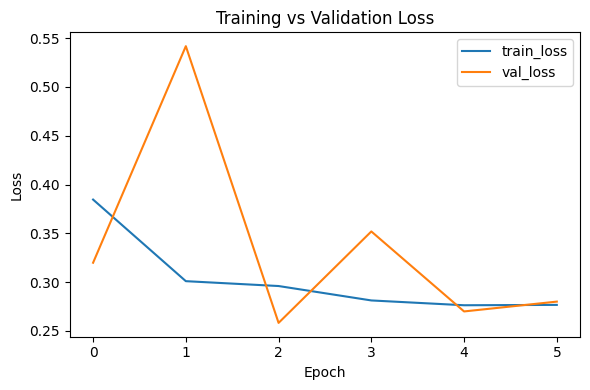

In [40]:
# Cell 7: training with early stopping

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2,
)

# Optional: plot training curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.tight_layout()
plt.show()



Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      5680
           1       0.64      0.87      0.74      1156

    accuracy                           0.90      6836
   macro avg       0.81      0.88      0.84      6836
weighted avg       0.92      0.90      0.90      6836

Confusion Matrix:
 [[5117  563]
 [ 152 1004]]


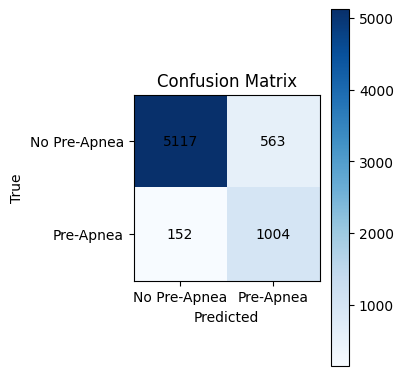

In [41]:
# Cell 8: Evaluation on Test Set

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["No Pre-Apnea", "Pre-Apnea"])
plt.yticks([0,1], ["No Pre-Apnea", "Pre-Apnea"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()
